<a href="https://colab.research.google.com/github/AKASH4671/Sentiment-Analysis-on-Financial-News-and-Its-Impact-on-Stock-Prices/blob/main/06_movement_prediction_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

!pip install xgboost
from xgboost import XGBClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sentence_transformers import SentenceTransformer
from scipy.sparse import hstack

**Mount Drive & load data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load merged sentiment + price movement data
file_path = "/content/drive/MyDrive/Colab Notebooks/Finance Projects/Sentiment-Analysis-on-Financial-News-and-Its-Impact-on-Stock-Prices/data/apple_sentiment_price_merged.csv"
df = pd.read_csv(file_path)

print(" Dataset shape:", df.shape)
df[['cleaned_text', 'sentiment', 'sentiment_score', 'movement']].head()


Mounted at /content/drive
 Dataset shape: (2541, 10)


,cleaned_text,sentiment,sentiment_score,movement
0,node lts nodejs free opensource crossplatform ...,Neutral,0.999738,1
1,marcelo see mozambique look futurepresident re...,Neutral,0.999268,1
2,masonic obedience issue statement defense peac...,Neutral,0.999991,1
3,express express delivery company refused accep...,Neutral,0.999938,1
4,almadadetained suspected attempted murder braz...,Neutral,0.999965,1


**class distribution**

Class Distribution:
 movement
 1    1268
 0     685
-1     588
Name: count, dtype: int64


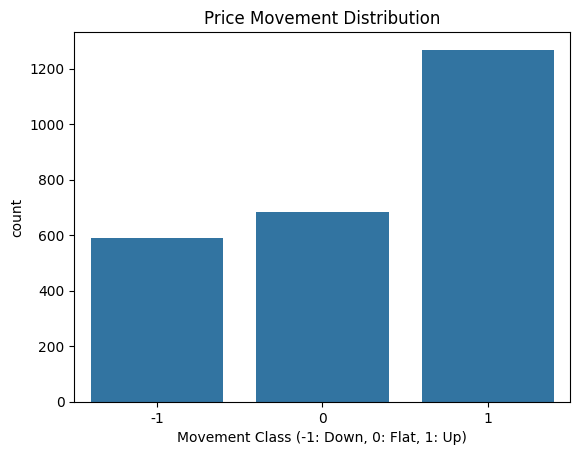

In [3]:
print("Class Distribution:\n", df['movement'].value_counts())
sns.countplot(x='movement', data=df)
plt.title("Price Movement Distribution")
plt.xlabel("Movement Class (-1: Down, 0: Flat, 1: Up)")
plt.show()

**balanced class**

Balanced class distribution:
 movement
-1    588
 1    588
 0    588
Name: count, dtype: int64


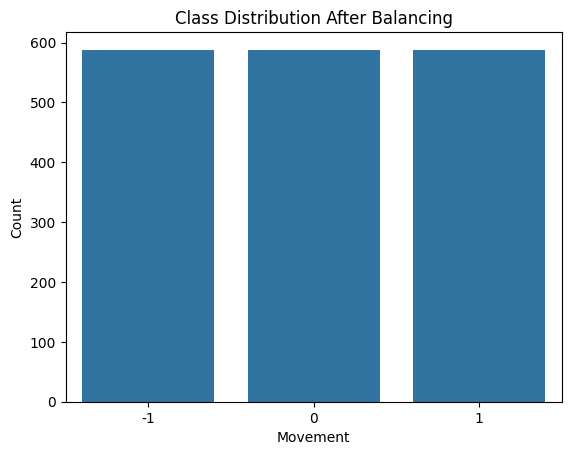

In [9]:
# Split by movement label
df_up = df[df['movement'] == 1]
df_down = df[df['movement'] == -1]
df_flat = df[df['movement'] == 0]

# Determine minimum class size
min_size = min(len(df_up), len(df_down), len(df_flat))

# Downsample all classes to match smallest class
df_up_balanced = resample(df_up, replace=False, n_samples=min_size, random_state=42)
df_down_balanced = resample(df_down, replace=False, n_samples=min_size, random_state=42)
df_flat_balanced = resample(df_flat, replace=False, n_samples=min_size, random_state=42)

# Combine into single DataFrame
df_balanced = pd.concat([df_up_balanced, df_down_balanced, df_flat_balanced])

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print("Balanced class distribution:\n", df_balanced['movement'].value_counts())

# visualization
sns.countplot(x='movement', data=df_balanced)
plt.title("Class Distribution After Balancing")
plt.xlabel("Movement")
plt.ylabel("Count")
plt.show()


**TF-IDF & test-train split**

In [10]:
# Features and labels
X = df_balanced['cleaned_text']
y = df_balanced['movement']

# TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


**logistic regression**

In [ ]:
# logistic regression
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.50      0.47       117
           0       0.43      0.34      0.38       118
           1       0.38      0.41      0.39       118

    accuracy                           0.42       353
   macro avg       0.42      0.42      0.41       353
weighted avg       0.42      0.42      0.41       353



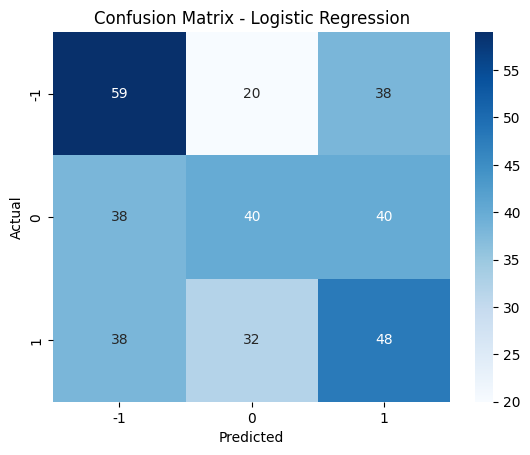

In [11]:
# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


**XGBoost**

In [14]:
# Load cleaned dataset
df = df_balanced.copy()

# If 'word_count' not already there
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

# Features and labels
X = df[['cleaned_text', 'sentiment_score', 'word_count']]
y = df['movement']

# Map target labels to 0, 1, 2
label_mapping = {-1: 0, 0: 1, 1: 2}
y_mapped = y.map(label_mapping)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.3, stratify=y_mapped, random_state=42)

# Preprocessing: Combine TF-IDF with numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1,2)), 'cleaned_text'),
        ('sent_score', FunctionTransformer(lambda x: x[['sentiment_score']].values, validate=False), ['sentiment_score']),
        ('word_count', FunctionTransformer(lambda x: x[['word_count']].values, validate=False), ['word_count']),
    ]
)

# XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# Fit model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Map predictions back to original labels for evaluation
reverse_label_mapping = {0: -1, 1: 0, 2: 1}
y_pred_original = pd.Series(y_pred).map(reverse_label_mapping).values
y_test_original = y_test.map(reverse_label_mapping).values


# Results
print("Classification Report:")
print(classification_report(y_test_original, y_pred_original))

print("Confusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))

Classification Report:
              precision    recall  f1-score   support

          -1       0.41      0.43      0.42       176
           0       0.45      0.38      0.41       177
           1       0.42      0.46      0.44       177

    accuracy                           0.42       530
   macro avg       0.43      0.42      0.42       530
weighted avg       0.43      0.42      0.42       530

Confusion Matrix:
[[76 40 60]
 [56 68 53]
 [52 44 81]]


**1. XGBoost on raw data**

**2. TF-IDF vectorization of news headlines**

**3. Feature combination (sentiment score, hour, weekday)**

**4. Feature importance visualization**

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:

              precision    recall  f1-score   support

   Down (-1)       0.65      0.86      0.74       117
    Flat (0)       0.79      0.82      0.80       118
     Up (+1)       0.68      0.43      0.53       118

    accuracy                           0.71       353
   macro avg       0.71      0.71      0.69       353
weighted avg       0.71      0.71      0.69       353


Confusion Matrix:


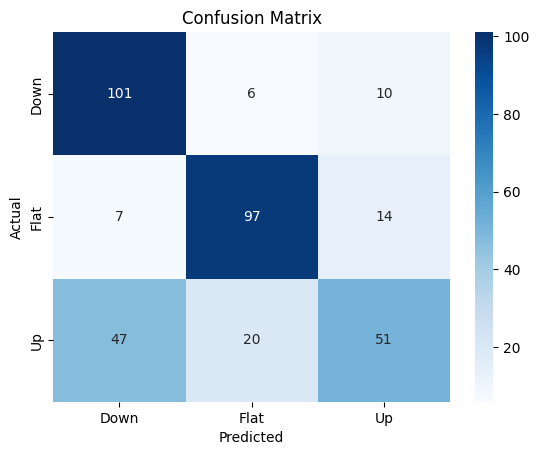

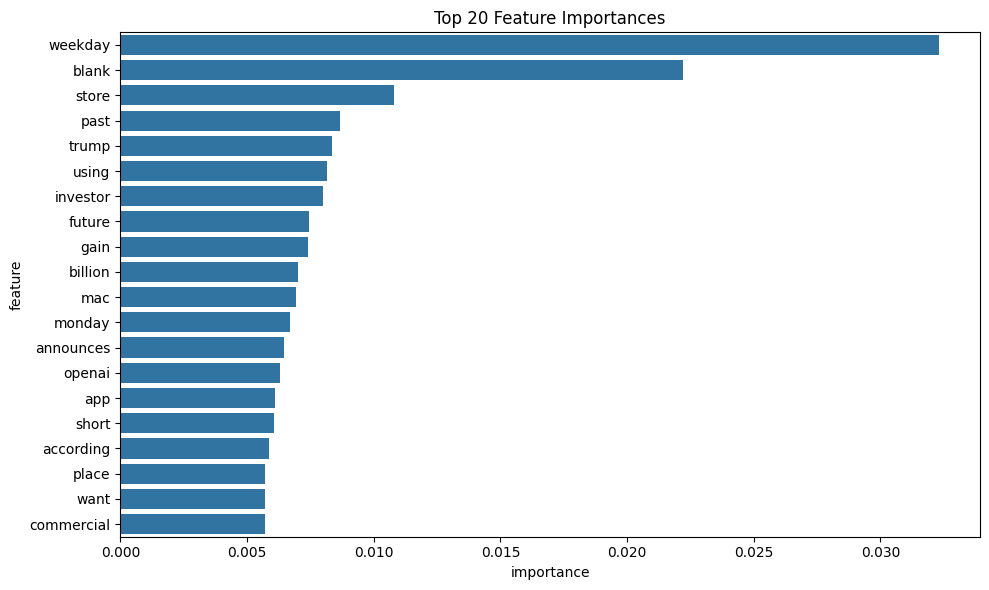

In [16]:
# Load data
df = df.copy()

# Feature Engineering
df['hour'] = pd.to_datetime(df['date']).dt.hour
df['weekday'] = pd.to_datetime(df['date']).dt.weekday

# Select features and label
features = df[['cleaned_text', 'sentiment_score', 'hour', 'weekday']]
label_mapping = {-1: 0, 0: 1, 1: 2}  # remap labels for XGBoost
labels = df['movement'].map(label_mapping)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(features['cleaned_text'])
X_other = features[['sentiment_score', 'hour', 'weekday']].values

# Combine TF-IDF + numerical features
X_combined = hstack([X_text, X_other])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42, stratify=labels)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Evaluation
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Down (-1)', 'Flat (0)', 'Up (+1)']))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Flat', 'Up'], yticklabels=['Down', 'Flat', 'Up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature Importance (top 20 text-based + sentiment, hour, weekday)
importances = xgb.feature_importances_
feature_names = vectorizer.get_feature_names_out().tolist() + ['sentiment_score', 'hour', 'weekday']
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp_df = feat_imp_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x="importance", y="feature")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

**Semantic Embeddings + Token Cleaning**

/tmp/ipython-input-20-165195150.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df['cleaned_text'].str.contains(r'\b(blank|none|nan)\b', na=False)]


🔍 Generating semantic embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:26:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Classification Report:

              precision    recall  f1-score   support

   Down (-1)       0.67      0.91      0.77       118
    Flat (0)       0.72      0.84      0.77       105
     Up (+1)       0.74      0.35      0.48       113

    accuracy                           0.70       336
   macro avg       0.71      0.70      0.67       336
weighted avg       0.71      0.70      0.67       336



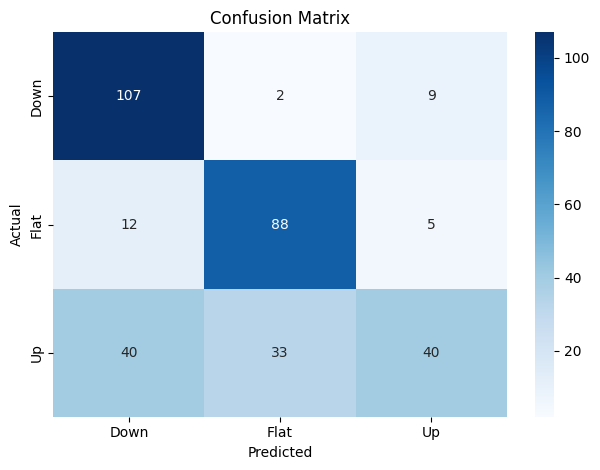

In [20]:
# Step 1: Clean "bad tokens"
df = df.copy()
df = df[~df['cleaned_text'].str.contains(r'\b(blank|none|nan)\b', na=False)]

# Step 2: Basic Feature Engineering
df['hour'] = pd.to_datetime(df['date']).dt.hour
df['weekday'] = pd.to_datetime(df['date']).dt.weekday

# Step 3: Labels and Features
label_mapping = {-1: 0, 0: 1, 1: 2}
y = df['movement'].map(label_mapping)
X_numerical = df[['sentiment_score', 'hour', 'weekday']].values

# Step 4: Semantic Embeddings
print("Generating semantic embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
X_text = model.encode(df['cleaned_text'].tolist(), show_progress_bar=True)

# Step 5: Combine embeddings with numerical features
X_combined = np.hstack([X_text, X_numerical])

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Step 7: Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Step 8: Evaluation
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Down (-1)', 'Flat (0)', 'Up (+1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Flat', 'Up'],
            yticklabels=['Down', 'Flat', 'Up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
